# Градиентный спуск и линейные модели

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from scipy.optimize import fmin_tnc
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

В основе метода лежит гипотеза, что целевой признак $y$ линейно зависит от матрицы исходных признаков $X$ ($k$ - количество признаков): $y \sim X$.

Тогда значение целевого признака $y$ можно аппроксимировать с помощью линейной функции $f(x,b)$:

$$ y = f(x,b) + \epsilon$$
$$ \hat{y} = f(x,b) $$
$$ y = \hat{y} + \epsilon$$
где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $\epsilon$ - ошибка модели


Ошибка всегда присутствует, ведь на практике нет никакой гарантии, что зависимость между исходными признаками и целевым признаком действительно линейная.

В модели линейной регресии $\hat{y} = f(x,b)$ можно представить как скалярное произведение вектора признаков (регрессоров или факторов) $x_i$ на вектор коэффициентов модели $b_i$:

$$ \hat{y} = f(x,b) = b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n $$

Коэффициент $b_0$ (константу) можно рассматривать как коэффициент при нулевом признаке, который всегда равен 1 ($x_0=1$). Тогда:

$$ \hat{y} = f(x,b) = b_0 \cdot x_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n = \sum\limits_{j=0}^N b_j \cdot x_j = x^T b $$

Построение модели линейной регресии означает нахождение всех коэффициентов $b_i$ на основании известных значений матрицы исходных признаков $X$ и вектора целевого признака $y$ из обучающей выборки.

Фактически, нужно найти такие значения $b_i$, которые минимизируют ошибку $\epsilon$.

Значение коэффициентов $b_i$ может быть найдено:
1. аналитически
1. с использованием численных методов (что используется на практике наиболее часто)

In [2]:
houses_df = pd.read_csv('data/kc_house_data_NaN.csv', sep = ',')
houses_df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
houses_df = houses_df.drop(houses_df.columns[0], axis=1)
houses_df = houses_df.drop('date', axis=1)
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   price          21613 non-null  float64
 2   bedrooms       21600 non-null  float64
 3   bathrooms      21603 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

<Axes: >

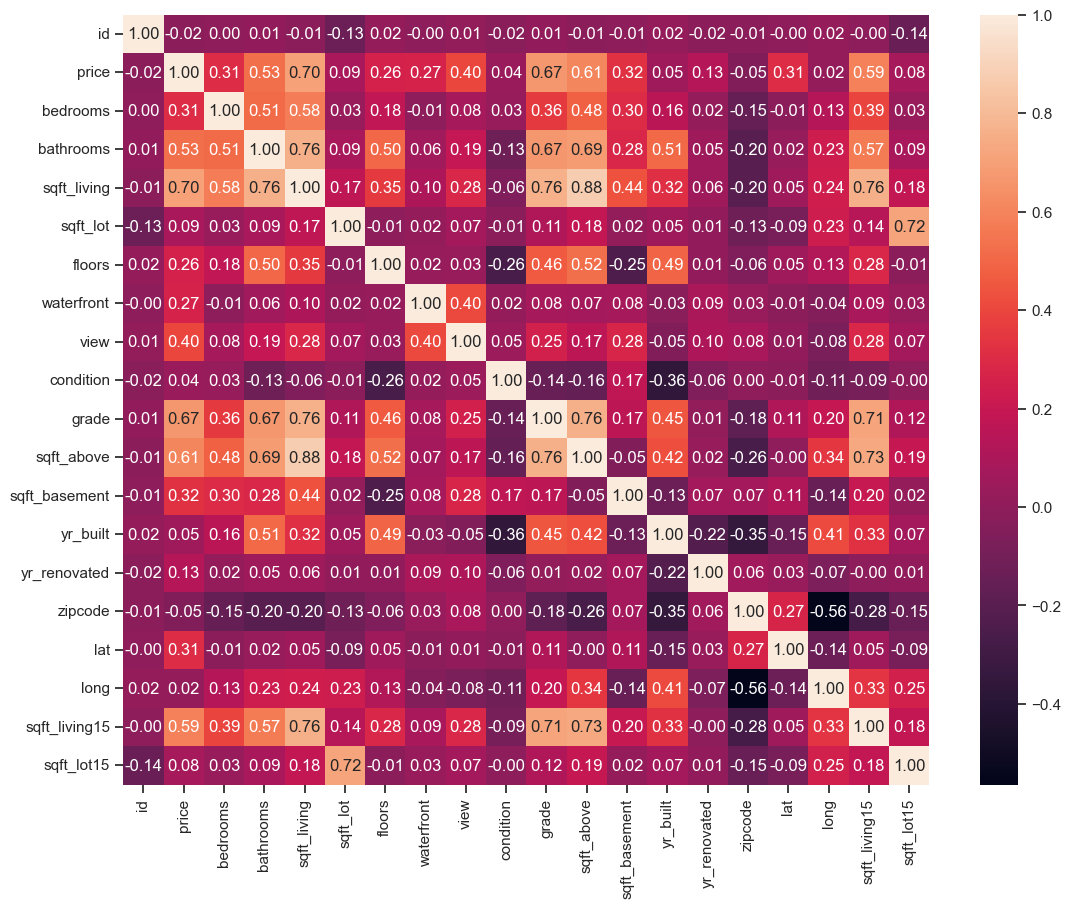

In [4]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(houses_df.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

<Axes: xlabel='sqft_living', ylabel='price'>

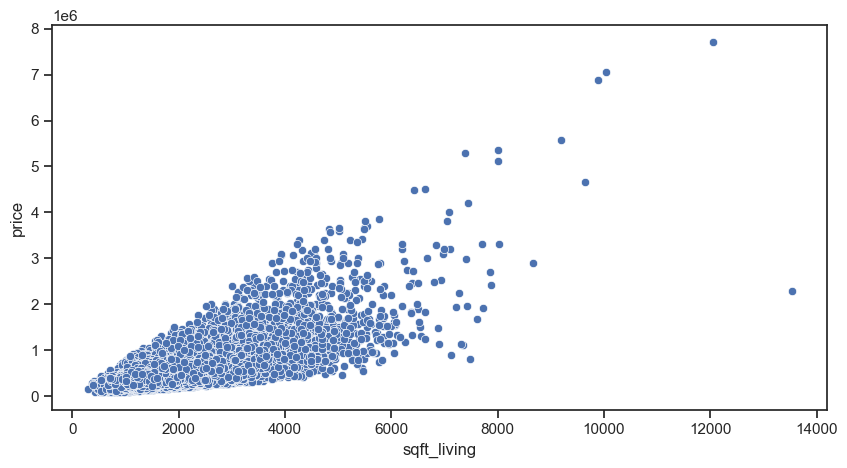

In [5]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.scatterplot(ax=ax, x='sqft_living', y='price', data=houses_df)

## Аналитическое восстановление зависимости

In [6]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

x_array = houses_df['sqft_living'].values
y_array = houses_df['price'].values

In [7]:
x_array.dtype

dtype('int64')

In [8]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(np.float64(-43580.74309447408), np.float64(280.6235678974483))

In [9]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [10]:
y_array_regr = y_regr(x_array, b0, b1)

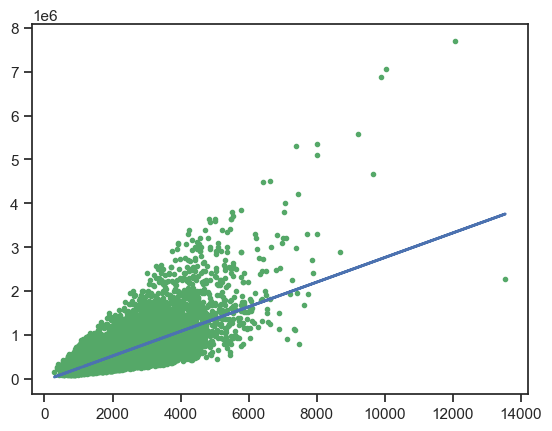

In [11]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

## Восстановление зависимости с использованием численных методов

Смысл использования всех численных методов сводится к тому, чтобы в выражении $y = \hat{y} + \epsilon$ минимизировать ошибку $\epsilon \rightarrow min$ (или какой-либо функцию от ошибки, называемую функцией потерь - $L$), то есть насколько это возможно приблизить предсказанные значения $\hat{y}$ к действительным значениям $y$.

Одним из наиболее часто используемых методов является метод наименьших квадратов.

### Метод наименьших квадратов

В методе наименьших квадратов в качестве функции потерь используется квадрат ошибки $\epsilon^2$.

Решается задача оптимизации:

$$ L = \epsilon^2 \rightarrow min = \sum\limits_{i=1}^k \epsilon_i^2 \rightarrow min = \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2 \rightarrow min $$

Проиллюстрируем метод наименьших квадратов. Для первых K=10 точек покажем ошибки между истинными и предсказанными значениями:

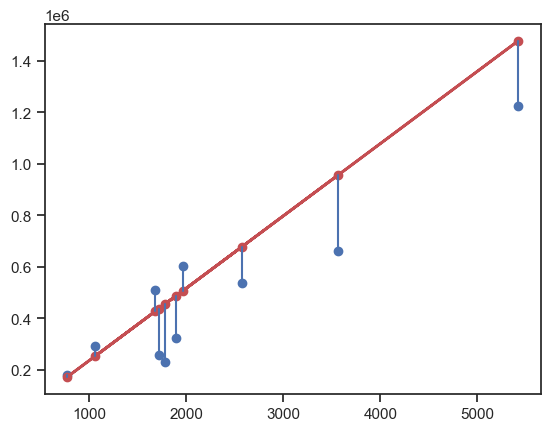

In [12]:
# Синими отрезками показаны ошибки между 
# истинными и предсказанными значениями
K_mnk=10

plt.plot(x_array[1:K_mnk+1], y_array[1:K_mnk+1], 'bo')
plt.plot(x_array[1:K_mnk+1], y_array_regr[1:K_mnk+1], '-ro', linewidth=2.0)

for i in range(len(x_array[1:K_mnk+1])):
    x1 = x_array[1:K_mnk+1][i]
    y1 = y_array[1:K_mnk+1][i]
    y2 = y_array_regr[1:K_mnk+1][i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

Использование метода наименьших квадратов предполагает решение задачи оптимизации одним из методов оптимизации. Одним из наиболее часто используемых методов является: 

## Градиентный спуск или метод наискорейшего спуска

Обычно в градиентном спуске рассматривается следующая функция потерь:

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2$$

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - (b_1 \cdot x_i + b_0))^2$$

Найдем частные производные функции потерь по коэффициентам регресии:

$$ \frac{\partial L}{\partial b_1} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 2 \cdot (y_i - (b_1 \cdot x_i + b_0)) \cdot (-x_i) =
\frac{-2}{k} \cdot \sum\limits_{i=1}^k x_i \cdot (y_i - \hat{y_i})  $$

$$ \frac{\partial L}{\partial b_0} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 2 \cdot (y_i - (b_1 \cdot x_i + b_0)) \cdot (-1) =
\frac{-2}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y_i})  $$


Будем двигаться с шагом $\lambda$ (learning rate) в направлении антиградиента, выполняя в цикле следующие действия:

$$ b_0 = b_0 - \lambda \cdot \frac{\partial L}{\partial b_0} $$

$$ b_1 = b_1 - \lambda \cdot \frac{\partial L}{\partial b_1} $$

Могут рассматриваться различные критерии остановки цикла. Наиболее простым критерием является сходимость значений коэффициентов - модуль разности между значениями коэффициентов на $i$ и $i-1$ шагах не превышает определенного порога $\epsilon^b$: $|b^i - b^{i-1}| < \epsilon^b$.

В простейшей реализации гиперпараметром алгоритма может являться фиксированное количество эпох.

In [13]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [14]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = -43580.74309447408 - (теоретический), -1.475862242978937e+39 - (градиентный спуск)
b1 = 280.6235678974483 - (теоретический), -3.6681751435930703e+42 - (градиентный спуск)
MSE = 6.955797382601886e+91


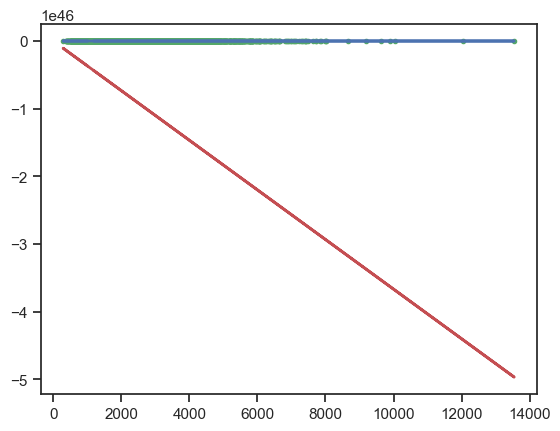

In [15]:
show_gradient_descent(10, 0, 0)

In [16]:
show_gradient_descent(1000, 0, 0)

C:\Users\bella\OneDrive\Рабочий стол\TMO_Labs\myenv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\bella\AppData\Local\Temp\ipykernel_8520\3253162523.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  b1 = b1 - learning_rate * dL_db1


b0 = -43580.74309447408 - (теоретический), nan - (градиентный спуск)
b1 = 280.6235678974483 - (теоретический), nan - (градиентный спуск)


ValueError: Input contains NaN.